** Aim: **

* Ensemble of different models
* Feature Engineering

In [57]:
%matplotlib inline

import pandas as pd
import numpy as np
import gc

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler


from tqdm import tqdm_notebook

import time
import xgboost as xgb
import xgbfir

sns.set_style('dark')

SEED = 53525
np.random.seed(SEED)

%run ../src/data/make_dataset.py
%run ../src/features/util.py
%run ../src/models/cross_validation.py

In [2]:
# map for detected camera

detected_camera_map = {
    'Front': 0,
    'Left': 1,
    'Rear': 2,
    'Right':3
}

In [3]:
data = load_file('../data/processed/processed.feather')
data['DetectedCamera'] = data.DetectedCamera.map(detected_camera_map)

train_mask = data.Target.notnull()

** Boxplot of angle between direction of vehicle and sign based on camera which detected it first. **

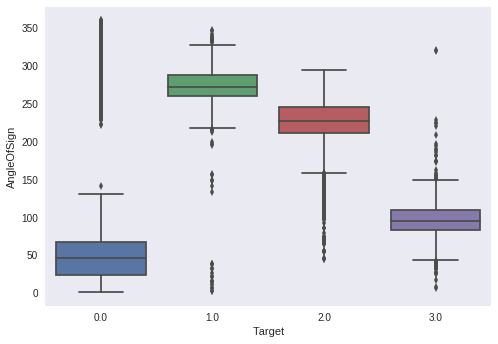

In [20]:
sns.boxplot(x='Target', y='AngleOfSign', data=data.loc[train_mask, :]);

** Let's figure out how angle of sign relates with Detected Camera and target **

In [10]:
ss = data.loc[train_mask & (data.Target == 0.0), ['AngleOfSign', 'DetectedCamera']]

In [11]:
ss.DetectedCamera.value_counts()

Front    10759
Right     9563
Left      1005
Name: DetectedCamera, dtype: int64

** It says the sign that is to be put on front road geometry is captured by only front, right or left facing cameras. **

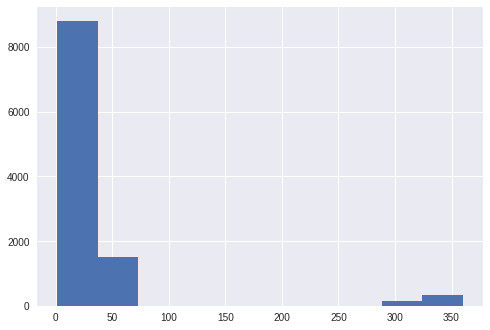

In [19]:
ss.loc[ss.DetectedCamera == 'Front', 'AngleOfSign'].hist();

** This makes perfect sense that theta lies between 0 and 90 and 270 and 360 **

In [17]:
ss.loc[ss.DetectedCamera == 'Right', 'AngleOfSign'].describe()

count    9563.000000
mean       64.024678
std        11.943280
min        41.000000
25%        55.000000
50%        65.000000
75%        72.000000
max       141.000000
Name: AngleOfSign, dtype: float64

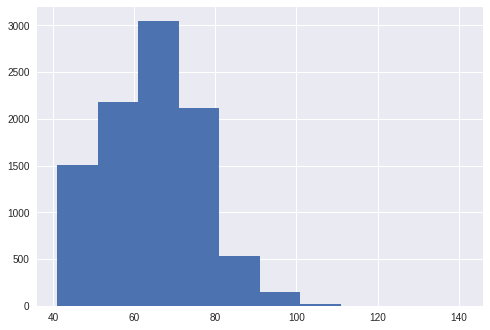

In [15]:
ss.loc[ss.DetectedCamera == 'Right', 'AngleOfSign'].hist();

In [18]:
ss.loc[ss.DetectedCamera == 'Left', 'AngleOfSign'].describe()

count    1005.000000
mean      280.385075
std        19.197495
min       222.000000
25%       265.000000
50%       279.000000
75%       295.000000
max       330.000000
Name: AngleOfSign, dtype: float64

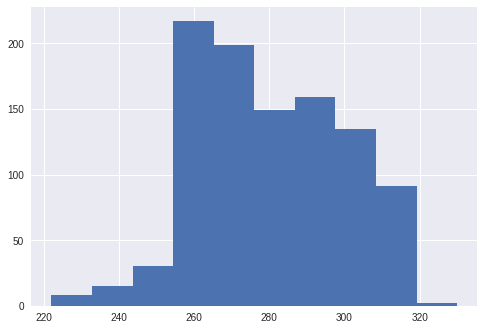

In [16]:
ss.loc[ss.DetectedCamera == 'Left', 'AngleOfSign'].hist();

** Left sign **

In [ ]:
0 - Front, 1 - Left, 2 - Rear, 3 - Right

In [143]:
ss = data.loc[train_mask & (data.Target == 3.0), ['AngleOfSign', 'DetectedCamera']]

In [144]:
ss.DetectedCamera.value_counts()

Right    700
Rear      71
Front     50
Name: DetectedCamera, dtype: int64

In [30]:
ss = data.loc[train_mask & (data.Target == 1.0), ['AngleOfSign', 'DetectedCamera']]

In [31]:
ss.DetectedCamera.value_counts()

Left     541
Front    101
Rear      33
Name: DetectedCamera, dtype: int64

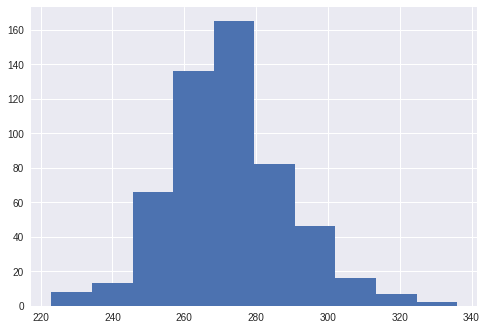

In [33]:
ss.loc[ss.DetectedCamera == 'Left', 'AngleOfSign'].hist();

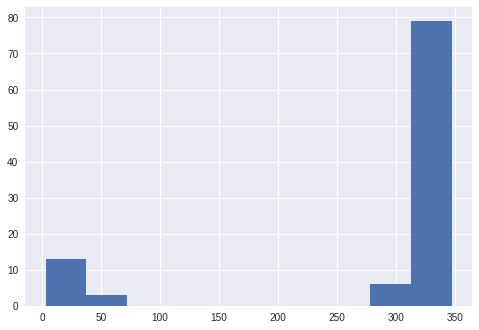

In [34]:
ss.loc[ss.DetectedCamera == 'Front', 'AngleOfSign'].hist();

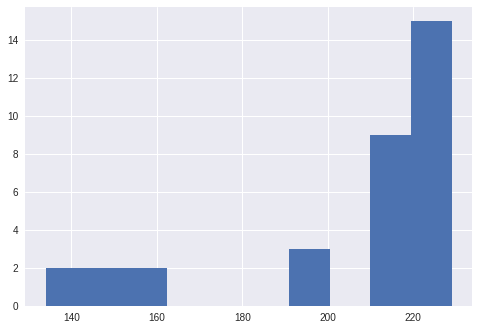

In [35]:
ss.loc[ss.DetectedCamera == 'Rear', 'AngleOfSign'].hist();

In [37]:
ss = data.loc[train_mask & (data.Target == 1.0), ['AngleOfSign', 'DetectedCamera', 'SignAspectRatio']]

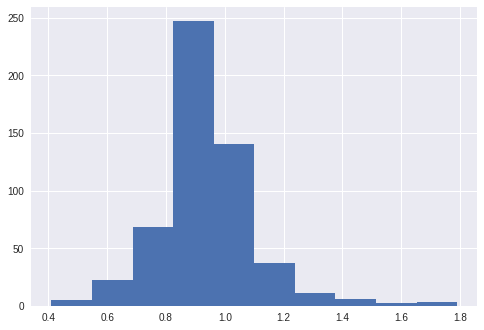

In [39]:
ss.loc[ss.DetectedCamera == 'Left', 'SignAspectRatio'].hist();

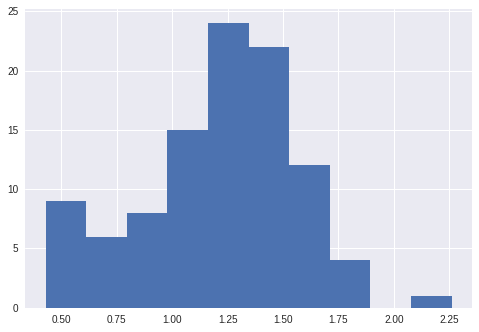

In [40]:
ss.loc[ss.DetectedCamera == 'Front', 'SignAspectRatio'].hist();

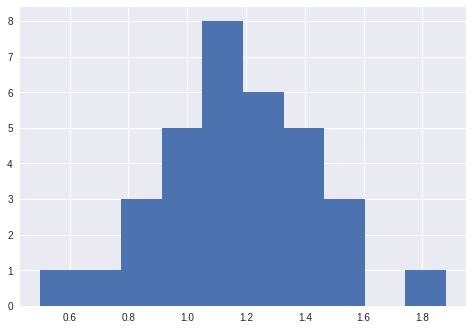

In [41]:
ss.loc[ss.DetectedCamera == 'Rear', 'SignAspectRatio'].hist();

** Relationship between detected camera and target **

In [8]:
data.loc[train_mask & (data.DetectedCamera == data.Target)].shape

(19657, 7)

In [9]:
data.loc[train_mask & (data.DetectedCamera != data.Target)].shape

(18828, 7)

In [10]:
data.loc[train_mask].shape

(38485, 7)

In [11]:
data.loc[train_mask & (data.DetectedCamera != data.Target)]

,AngleOfSign,DetectedCamera,Id,SignAspectRatio,SignHeight,SignWidth,Target
6,245,1,2c9180975a056a64015a1e01fd466f56,0.93,117,109,2.0
9,74,3,2c9180975a056a64015a1e01fd466f51,0.51,103,53,0.0
14,258,1,2c9180975a056a64015a1e04ad9f6f8b,0.48,81,39,2.0
21,49,3,2c9180975a056a64015a1e04ad9f6f83,1.04,122,127,0.0
27,76,3,2c9180975a056a64015a1e1d735c7293,0.64,102,65,0.0
29,253,1,2c9180975a056a64015a1e41bbc2775f,0.69,54,37,2.0
30,248,1,2c9180975a056a64015a1e41bbc27758,0.75,59,44,2.0
31,72,3,2c9180975a056a64015a1e41bbc27756,0.55,94,52,0.0
33,253,1,2c9180975a056a64015a1e13b6c7713e,0.43,87,37,2.0
37,43,3,2c9180975a056a64015a1dceefde69de,1.20,167,200,0.0


** Relationship between Sign Area and Target **

In [4]:
sign_area = data.SignHeight * data.SignWidth

data = data.assign(sign_area=sign_area)

/home/abhishek/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


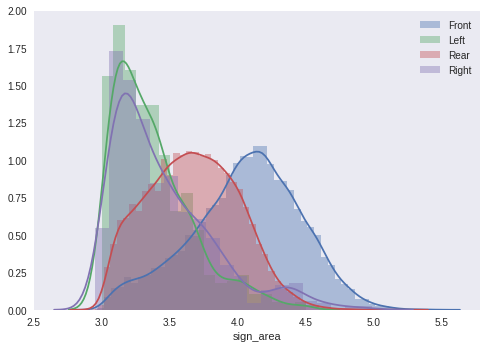

In [18]:
sns.distplot(data.loc[train_mask & (data.Target == 0.0), 'sign_area'].map(np.log10), label='Front')
sns.distplot(data.loc[train_mask & (data.Target == 1.0), 'sign_area'].map(np.log10), label='Left')
sns.distplot(data.loc[train_mask & (data.Target == 2.0), 'sign_area'].map(np.log10), label='Rear')
sns.distplot(data.loc[train_mask & (data.Target == 3.0), 'sign_area'].map(np.log10), label='Right')
plt.legend(loc='best');

In [5]:
sign_perimeter = 2 * (data.SignHeight + data.SignWidth)

data = data.assign(sign_perimeter=sign_perimeter)

/home/abhishek/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


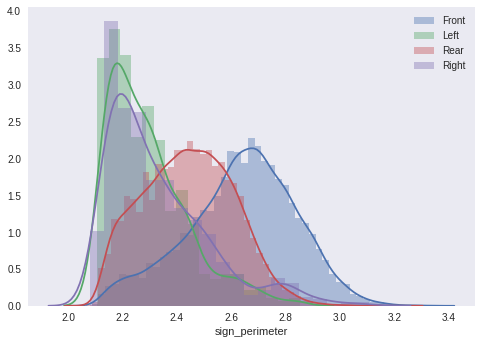

In [117]:
sns.distplot(data.loc[train_mask & (data.Target == 0.0), 'sign_perimeter'].map(np.log10), label='Front')
sns.distplot(data.loc[train_mask & (data.Target == 1.0), 'sign_perimeter'].map(np.log10), label='Left')
sns.distplot(data.loc[train_mask & (data.Target == 2.0), 'sign_perimeter'].map(np.log10), label='Rear')
sns.distplot(data.loc[train_mask & (data.Target == 3.0), 'sign_perimeter'].map(np.log10), label='Right')

plt.legend(loc='best');

In [6]:
diff_height_width = data.SignHeight - data.SignWidth

data = data.assign(diff_height_width=diff_height_width)

/home/abhishek/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


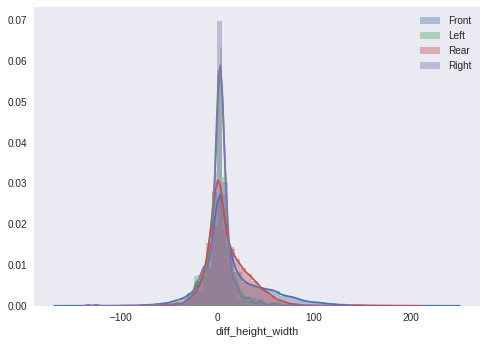

In [154]:
sns.distplot(data.loc[train_mask & (data.Target == 0.0), 'diff_height_width'], label='Front')
sns.distplot(data.loc[train_mask & (data.Target == 1.0), 'diff_height_width'], label='Left')
sns.distplot(data.loc[train_mask & (data.Target == 2.0), 'diff_height_width'], label='Rear')
sns.distplot(data.loc[train_mask & (data.Target == 3.0), 'diff_height_width'], label='Right')

plt.legend(loc='best');

** Relationship between Sign, other features and target **

In [33]:
sar_labels = pd.cut(data.SignAspectRatio, bins=5, labels=np.arange(1, 6))

data = data.assign(sar_labels=sar_labels)

In [47]:
mean_target_by_sar_labels = data.loc[train_mask, :]\
                              .groupby(['DetectedCamera', 'sar_labels'])['Target']\
                              .mean()

data = data.assign(mean_target_by_sar=data[['DetectedCamera', 'sar_labels']]\
           .apply(lambda x: mean_target_by_sar_labels.ix[x[0], x[1]] if (x[0], x[1]) in mean_target_by_sar_labels else -1, axis=1))

In [48]:
data.iloc[0]

AngleOfSign                                        195
DetectedCamera                                       2
Id                    2c9180975a056a64015a1e0a52e57021
SignAspectRatio                                   1.02
SignHeight                                          45
SignWidth                                           46
Target                                               2
sign_area                                         2070
sign_perimeter                                     182
diff_height_width                                   -1
closest_quadrant                                   180
mean_target                                    2.00439
sar_labels                                           2
mean_target_by_sar                             2.00056
Name: 0, dtype: object

** Feature Engineering **

** Closest quadrant line **

In [7]:
def get_closest_qudrant(angle):
    if angle >= 0 and angle <= 90:
        diff_from_0  = angle - 0
        diff_from_90 = 90 - angle
        
        if diff_from_0 < diff_from_90:
            return 0
        else:
            return 90
    
    elif angle > 90 and angle <= 180:
        diff_from_90  = angle - 90
        diff_from_180 = 180 - angle
        
        if diff_from_90 < diff_from_180:
            return 90
        else:
            return 180
    
    elif angle > 180 and angle <= 270:
        diff_from_180 = angle - 180
        diff_from_270 = 270 - angle
        
        if diff_from_180 < diff_from_270:
            return 180
        else:
            return 270
    
    else:
        diff_from_270 = angle - 270
        diff_from_360 = 360 - angle
        
        if diff_from_270 < diff_from_360:
            return 270
        else:
            return 360
    
data = data.assign(closest_quadrant=data.AngleOfSign.map(get_closest_qudrant))

** Mean Target **

In [8]:
mean_target_by_quadrant = data.loc[train_mask, :]\
                              .groupby(['DetectedCamera', 'closest_quadrant'])['Target']\
                              .mean()

data = data.assign(mean_target=data[['DetectedCamera', 'closest_quadrant']]\
                              .apply(lambda x: mean_target_by_quadrant.ix[x[0], x[1]], axis=1))

** Sign Area and Detected Camera looks very promising features to discriminate between different target labels. **

In [9]:
def cross_validate_single_model_sign(X, y, model, ret_fold_preds=False,
                   save_folds=False, plot_cv_scores=False):
    """
    Stratified K-Fold with 10 splits and then save each fold
    and analyze the performance of the model on each fold
    """
    
    skf = StratifiedKFold(n_splits=10, random_state=SEED)
    fold_counter = 0
    
    cv_scores = []
    preds     = []
    
    for (itr, ite) in tqdm_notebook(skf.split(X, y)):
        Xtr = X.iloc[itr]
        ytr = y.iloc[itr]
        
        Xte = X.iloc[ite]
        yte = y.iloc[ite]
        
        if save_folds:
            save_file(pd.concat((Xtr, ytr), axis='columns'), '../data/processed/train_fold%s.feather'%(fold_counter))
            save_file(pd.concat((Xte, yte), axis='columns'), '../data/processed/test_fold%s.feather'%(fold_counter))
        
        print('Training model')
        start_time = time.time()
        model.fit(Xtr, ytr)
        end_time   = time.time()
        
        print('Took: {} seconds to train model'.format(end_time - start_time))
        
        start_time  = time.time()
        fold_preds  = model.predict_proba(Xte)
        end_time    = time.time()
        
#         # platt - scaling
#         fold_train_preds = model.predict_proba(Xtr) # generate predictions for training fold
        
#         lr = LogisticRegression(C=.1, random_state=SEED)
#         lr.fit(fold_train_preds, ytr) # train a lr on predicted probs and true labels
        
#         calibrated = lr.predict_proba(fold_preds) # generate calibrated prob
        
        if ret_fold_preds:
            preds.append(fold_preds)
        
        print('Took: {} seconds to generate predictions'.format(end_time - start_time))
        
        fold_score = log_loss(yte, fold_preds)
        print('Fold log loss score: {}'.format(fold_score))
        
        cv_scores.append(fold_score)
        print('='*75)
        print('\n')
        
    if plot_cv_scores:
        plt.scatter(np.arange(0, len(cv_scores)), cv_scores)
    
    print('Mean cv score: {} \n Std cv score: {}'.format(np.mean(cv_scores), np.std(cv_scores)))
    
    return preds

In [53]:
ff = ['AngleOfSign', 'DetectedCamera',
      'mean_target', 'sign_area', 'sign_perimeter',
      'diff_height_width', 'SignAspectRatio'
     ]

X = data.loc[train_mask, ff]
y = data.loc[train_mask, 'Target']

Xtest = data.loc[~train_mask, ff]

In [54]:
params = {
    'stratify': y,
    'test_size': .2,
    'random_state': SEED
}

X_train, X_test, y_train, y_test = get_train_test_split(X, y, **params)

In [55]:
model = xgb.XGBClassifier(n_estimators=300, learning_rate=.1, max_depth=2, seed=SEED)
# model = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=SEED, n_jobs=-1)
# model = ExtraTreesClassifier(n_estimators=1000, max_depth=15, random_state=SEED)
# model = KNeighborsClassifier(n_neighbors=10, n_jobs=-1)

In [56]:
params = {
    'ret_fold_preds': True,
    'save_folds': False,
    'plot_cv_scores': False
}

cv_scores = cross_validate_single_model_sign(X_train, y_train, model, **params)

Training model
Took: 3.275162935256958 seconds to train model
Took: 0.041495323181152344 seconds to generate predictions
Fold log loss score: 0.10217235047931389


Training model
Took: 3.2509641647338867 seconds to train model
Took: 0.037377357482910156 seconds to generate predictions
Fold log loss score: 0.11459530713230619


Training model
Took: 3.245255470275879 seconds to train model
Took: 0.041985511779785156 seconds to generate predictions
Fold log loss score: 0.10228470807479577


Training model
Took: 3.24623966217041 seconds to train model
Took: 0.03735232353210449 seconds to generate predictions
Fold log loss score: 0.10730814367994232


Training model
Took: 3.887350082397461 seconds to train model
Took: 0.09739851951599121 seconds to generate predictions
Fold log loss score: 0.10606337718999514


Training model
Took: 3.2943713665008545 seconds to train model
Took: 0.03731203079223633 seconds to generate predictions
Fold log loss score: 0.10247149355823265


Training model
Too

In [67]:
def cv_multiple_models(X, y, feature_sets, models):
    skf = StratifiedKFold(n_splits=10, random_state=SEED)
    
    model_scores = [[] for _ in models]
    cv_scores    = []
    fold_index   = 0
    
    for (itr, ite) in tqdm_notebook(skf.split(X, y)):
        Xtr = X.iloc[itr]
        ytr = y.iloc[itr]
        
        Xte = X.iloc[ite]
        yte = y.iloc[ite]
        
        predictions       = []
#         train_predictions = [] # for platt scaling
        
        for i, model in enumerate(models):
            print('Training model: {}'.format(i))
            curr_model = model.fit(Xtr.loc[:, feature_sets[i]], ytr)    
            model_pred = curr_model.predict_proba(Xte.loc[:, feature_sets[i]])
#             train_pred = curr_model.predict_proba(Xtr.loc[:, feature_sets[i]])
            predictions.append(model_pred)
#             train_predictions.append(train_pred)
            model_scores[i].append(log_loss(yte, model_pred))
        
        predictions = np.array(predictions)
        weights = [.15 , .15, .7]
        
        vot = predictions[0] * weights[0]
#         train_vot = train_predictions[0] * weights[0]
        
        for i in range(1, len(predictions)):
            vot = vot + predictions[i] * weights[i]
            
#         vot /= len(predictions)

#         # platt scaling
#         lr = LogisticRegression()
#         lr.fit(train_vot, ytr)
        
#         calibrated_preds = lr.predict_proba(vot)

        curr_metric = log_loss(yte, vot)
        cv_scores.append(curr_metric)
        print('split # {}, score = {}, models scores std = {}'\
            .format(fold_index, curr_metric,
            np.std([scr[fold_index] for scr in model_scores])))
        
        fold_index += 1
        
        print('=' * 75)
        
    print()
    print(cv_scores)
    print(np.mean(cv_scores), np.std(cv_scores))
    print()

In [65]:
model_etc = ExtraTreesClassifier(n_estimators=1000, max_depth=15, n_jobs=-1, random_state=SEED)
model_rf  = RandomForestClassifier(n_estimators=1000, n_jobs=-1, max_depth=10, min_samples_split=2, random_state=SEED)
model_xgb = xgb.XGBClassifier(n_estimators=300, learning_rate=.1, max_depth=2, seed=SEED)

In [68]:
feature_sets = [ff, ff, ff]

cv_multiple_models(X_train, y_train, feature_sets, [model_etc, model_rf, model_xgb])

Training model: 0
Training model: 1

Training model: 2
split # 0, score = 0.10146852689848208, models scores std = 0.0035633376421670836
Training model: 0
Training model: 1
Training model: 2
split # 1, score = 0.11514402643604853, models scores std = 0.006730205279735578
Training model: 0
Training model: 1
Training model: 2
split # 2, score = 0.10169664057884359, models scores std = 0.005294100040983342
Training model: 0
Training model: 1
Training model: 2
split # 3, score = 0.10765175038602737, models scores std = 0.005709739554674102
Training model: 0
Training model: 1
Training model: 2
split # 4, score = 0.10585047734380808, models scores std = 0.006307093011912594
Training model: 0
Training model: 1
Training model: 2
split # 5, score = 0.10115567522202892, models scores std = 0.004309100178589876
Training model: 0
Training model: 1
Training model: 2
split # 6, score = 0.08384663599644165, models scores std = 0.006524311745391059
Training model: 0
Training model: 1
Training model: 2

** Analyzing mistakes **

In [81]:
labels = ['Front', 'Left', 'Rear', 'Right']

In [137]:
model_xgb.fit(X_train, y_train)

rt_probs    = model_rf.predict_proba(X_test)
rt_labels   = pd.Series(list(map(lambda x: labels[int(np.argmax(x))], rt_probs)))
true_labels = pd.Series(list(map(lambda x: labels[int(x)], y_test)))

In [138]:
mistakes    = X_test.loc[(rt_labels != true_labels).values, :]
mistakes    = mistakes.assign(rt_label=rt_labels.loc[(rt_labels != true_labels)\
                                                                       .values].values)
mistakes    = mistakes.assign(true_label=true_labels.loc[(rt_labels != true_labels).values].values) 

In [142]:
mistakes.head()

,AngleOfSign,DetectedCamera,mean_target,sign_area,sign_perimeter,rt_label,true_label
22924,257,1,1.725445,2112,184,Rear,Left
38152,252,1,1.725445,1332,146,Rear,Left
1690,266,1,1.725445,1677,164,Front,Rear
32611,103,3,0.250322,3712,244,Right,Front
21611,270,1,1.725445,3477,236,Front,Left


In [146]:
data.iloc[mistakes.head().index]

,AngleOfSign,DetectedCamera,Id,SignAspectRatio,SignHeight,SignWidth,Target,sign_area,closest_quadrant,mean_target,sign_perimeter
22924,257,1,8a5e950953317c9d01534a56159b0a59,1.09,44,48,1.0,2112,270,1.725445,184
38152,252,1,2c91809659f86230015a01b096ee165b,0.97,37,36,1.0,1332,270,1.725445,146
1690,266,1,2c91808b58e456050159341ab99a5a4f,0.91,43,39,2.0,1677,270,1.725445,164
32611,103,3,2c9180935a71a2bb015aa6be27ed27f8,1.10,58,64,0.0,3712,90,0.250322,244
21611,270,1,2c91808b564673aa0156481d6e0c0708,0.93,61,57,1.0,3477,270,1.725445,236


** Test on holdout set **

In [15]:
st = time.time()

# model_rf.fit(X_train, y_train)
model.fit(X_train, y_train)

et = time.time()

# rf_preds  = model_rf.predict_proba(X_test)
xgb_preds = model.predict_proba(X_test)

# preds = .40 * rf_preds + .60 * xgb_preds

print('Took: {} seconds to train all 2 models '.format(et - st))
print('Score on holdout set: {}'.format(log_loss(y_test, xgb_preds)))

Took: 3.778808116912842 seconds to train all 2 models 
Score on holdout set: 0.10799784935790852


** Feature Importance **

In [16]:
xgbfir.saveXgbFI(model, feature_names=ff, OutputXlsxFile = '../data/interim/FI_sign.xlsx')

** Full Training **

In [173]:
st = time.time()

model_rf.fit(X, y)
model_xgb.fit(X, y)

et = time.time()

rf_preds  = model_rf.predict_proba(Xtest)
xgb_preds = model_xgb.predict_proba(Xtest)

preds = .40 * rf_preds + .60 * xgb_preds

print('Took: {} seconds to train all 2 models '.format(et - st))

Took: 16.01654362678528 seconds to train all 2 models 


In [174]:
sub = pd.read_csv('../data/raw/4b699168-4-here_dataset/sample_submission.csv')
sub.loc[:, ['Front', 'Left', 'Rear', 'Right']] = preds
sub.to_csv('../submissions/predict_sign/ensemble_experiment15_diff_height_width.csv', index=False)